# Multiproduct Linear Monopolist

In [2]:
import numpy as np
import pandas as pd
from scipy import sparse
from math import sqrt, ceil
from timeit import default_timer as timer
from datetime import timedelta
import sys
sys.path.append('..')
from modules import LinearMonopolist

## Setting 1

In [2]:
### Types setting
c = 2
n0, n1 = 40, 40
theta0, theta1 =  np.linspace(c, c+1, num=n0, dtype=np.float32), np.linspace(c, c+1, num=n1, dtype=np.float32)  #  [1, 1.5, 3], [0, 0.5, 1]
theta0, theta1 = np.meshgrid(theta0,theta1)
theta = np.stack((theta0.flatten(), theta1.flatten())); N = theta.shape[-1]     # number of types

# theta = np.array([[1, 0, 0.5], [0, 1, 0.5]]);  N = theta.shape[-1]     # number of types

f = np.ones(N, dtype=np.float32).flatten()    # weights of the distribution

### Model parameters setting
param = {'substituable':True}   # False for indivisible goods (constraints = cube), True for substituable goods (constraints = simplex)

### Objects
model = LinearMonopolist(theta, f, param)

model id = LinearMonopolist_N1600_2024-03-07_14-03-51



## Direct resolution (with all the constraints)

convergence = True, iterations = 23981, elapsed time = 0:00:14.620526
primal residual = 9.89e-01 tol, dual residual = 2.73e-01 tol
primal-dual gap = 4.91e+02, optimal value - current value < 9.63e-01 optimal value


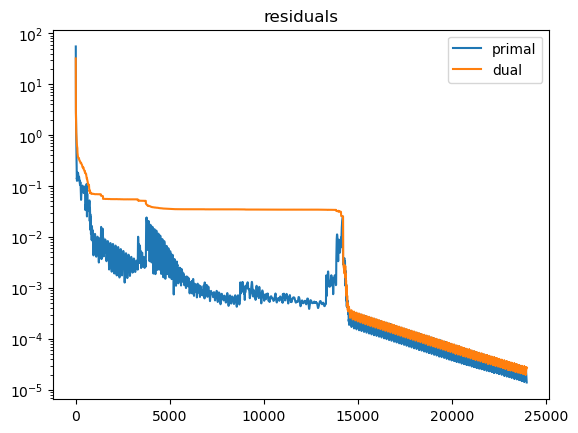

In [127]:
model.all()
model.solve(stepratio=1, it_max=1e5, tol_primal=1e-6, tol_dual=1e-6, scale=True,) #path='results/'+model.id
model.residuals(title='residuals')

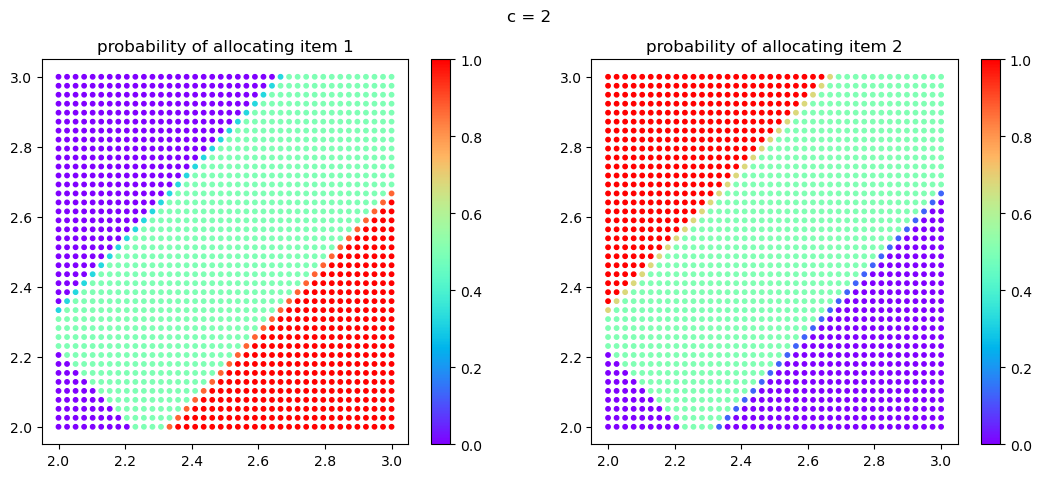

In [16]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(13,5),) # subplot_kw=dict(aspect='equal',))
item1 = axs[0].scatter(theta[0], theta[1], c = model.y[:model.N], s=10, cmap='rainbow')
_ = fig.colorbar(item1)
_ = axs[0].set_title('probability of allocating item 1')
item2 = axs[1].scatter(theta[0], theta[1], c = model.y[model.N:], s=10, cmap='rainbow')
_ = fig.colorbar(item2)
_ = axs[1].set_title('probability of allocating item 2')
_ = fig.suptitle(f'c = {c}')

In [12]:
path = 'results/'+model.id
fig.savefig(path, bbox_inches="tight", pad_inches=0.05)

In [8]:
atol = 1e-6
y0_0 = np.isclose(model.y[:model.N],0, atol=atol)
y0_1 = np.isclose(model.y[:model.N],1, atol=atol, rtol=0)
y1_0 = np.isclose(model.y[model.N:],0, atol=atol)
y1_1 = np.isclose(model.y[model.N:],1, atol=atol, rtol=0)

y_00 = np.flatnonzero(np.logical_and(y0_0, y1_0))
y_01 = np.flatnonzero(np.logical_and(y0_0, y1_1))
y_10 = np.flatnonzero(np.logical_and(y0_1, y1_0))
y_11 = np.flatnonzero(np.logical_and(y0_1, y1_1))

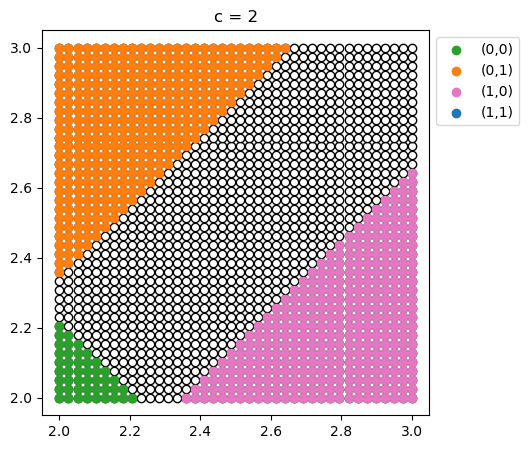

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
_ = ax.scatter(theta[0], theta[1], facecolors='w',edgecolors='k')
_ = ax.scatter(theta[0, y_00], theta[1, y_00], c='tab:green', label='(0,0)')
_ = ax.scatter(theta[0, y_01], theta[1, y_01], c='tab:orange', label='(0,1)')
_ = ax.scatter(theta[0, y_10], theta[1, y_10], c='tab:pink', label='(1,0)')
_ = ax.scatter(theta[0, y_11], theta[1, y_11], c='tab:blue', label='(1,1)')
_ = ax.legend(bbox_to_anchor=(1, 1),loc='upper left') #bbox_to_anchor=(0., -.13, 1., .1), loc='lower left', ncols=4, mode="expand", borderaxespad=0.) #(bbox_to_anchor=(1.02, 1.), loc='lower right')
_ = ax.set_title(f'c = {c}')

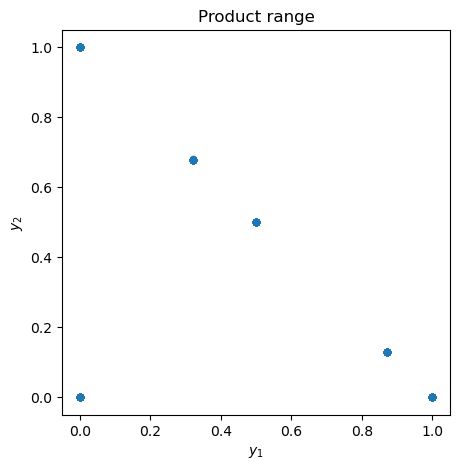

In [15]:
model.range(title='Product range', ) #path='results/'+model.id+'_products')
# model.constraints(path='results/'+model.id+'_constraints')

## Setting 2

In [21]:
### Types setting
c = 0.05
n0, n1 = 100, 100
theta0, theta1 =  np.linspace(c, c+1, num=n0, dtype=np.float32), np.linspace(c, c+1, num=n1, dtype=np.float32)  #  [1, 1.5, 3], [0, 0.5, 1]
theta0, theta1 = np.meshgrid(theta0,theta1)
theta = np.stack((theta0.flatten(), theta1.flatten())); N = theta.shape[-1]     # number of types

f = np.ones(N, dtype=np.float32).flatten()    # weights of the distribution

### Objects
model = LinearMonopolist(theta, f)

model id = LinearMonopolist_N10000_2024-02-06_22-00-11



## Adaptative approach (starting with the local constraints)

In [3]:
kmax = ceil(sqrt(N))+1
t_start = timer()
model.local(); k = 0; test = np.array([False,False])
while np.all(test==False):
    k += 1
    print(f'OPTIMIZATION {k}: {len(model.indices)} IC constraints')
    model.solve(warmstart=True, it_max = 1e5, stepratio=1,) # path='results/'+model.id) #sqrt(len(model.indices)) #len(model.indices)
    # model.residuals()
    print(f'IC constraints: {len(model.IC_binding)} binding, {len(model.IC_violated)} violated\n')
    # model.indices = sorted(set(model.indices).union(model.IC_violated))
    model.indices = sorted(set(model.indices).union(set(model.IC_violated).intersection(model.ind_local(k*ceil(sqrt(N))))))
    model.local(model.indices)
    test = np.array([k==kmax, len(model.IC_violated)==0])
elapsed = timer() - t_start
print(f'elapsed time = {str(timedelta(seconds=elapsed))}')

OPTIMIZATION 1: 3120 IC constraints
convergence = True, iterations = 1335, elapsed time = 0:00:16.634980
primal residual = 9.70e-01 tol, dual residual = 9.83e-01 tol
primal-dual gap = 3.13e+03, optimal value - current value < 9.09e-01 optimal value
IC constraints: 2320 binding, 908410 violated

OPTIMIZATION 2: 48847 IC constraints
convergence = False, iterations = 100000, elapsed time = 0:43:45.400399
primal residual = 5.44e+01 tol, dual residual = 5.37e+01 tol
primal-dual gap = nan, optimal value - current value < nan optimal value
IC constraints: 12260 binding, 476607 violated

OPTIMIZATION 3: 73223 IC constraints
convergence = False, iterations = 100000, elapsed time = 0:21:31.140058
primal residual = 2.07e+01 tol, dual residual = 1.09e+01 tol
primal-dual gap = nan, optimal value - current value < nan optimal value
IC constraints: 17050 binding, 270449 violated

OPTIMIZATION 4: 97455 IC constraints
convergence = False, iterations = 100000, elapsed time = 0:23:51.138071
primal residu

convergence = False, iterations = 100000, elapsed time = 0:13:22.823426
primal residual = 1.73e+01 tol, dual residual = 2.04e+00 tol
primal-dual gap = 3.16e+03, optimal value - current value < 9.26e-01 optimal value


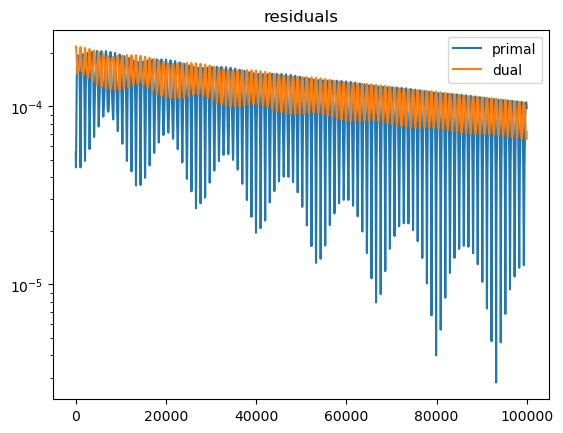

In [14]:
model.solve(stepratio=1, it_max=1e5, tol_primal=1e-7, tol_dual=1e-7, scale=True, warmstart=True)
model.residuals(title='residuals')

In [1]:
atol = 1e-6
y0_0 = np.isclose(model.y[:model.N],0, atol=atol)
y0_1 = np.isclose(model.y[:model.N],1, atol=atol, rtol=0)
y1_0 = np.isclose(model.y[model.N:],0, atol=atol)
y1_1 = np.isclose(model.y[model.N:],1, atol=atol, rtol=0)

y_00 = np.flatnonzero(np.logical_and(y0_0, y1_0))
y_01 = np.flatnonzero(np.logical_and(y0_0, y1_1))
y_10 = np.flatnonzero(np.logical_and(y0_1, y1_0))
y_11 = np.flatnonzero(np.logical_and(y0_1, y1_1))
# y_else = np.flatnonzero(np.logical_or(np.logical_and(~y0_0, ~y0_1), np.logical_and(~y1_0, ~y1_1)))

NameError: name 'np' is not defined

NameError: name 'theta' is not defined

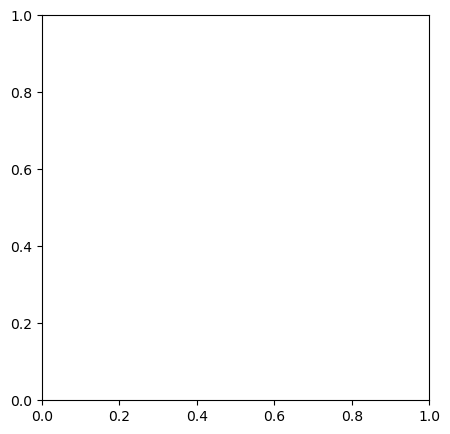

In [2]:
import matplotlib.pyplot as plt
s = 20
fig, ax = plt.subplots(figsize=(5,5))
_ = ax.scatter(theta[0], theta[1], s=s, facecolors='w',edgecolors='k')
_ = ax.scatter(theta[0, y_00], theta[1, y_00], s=s, c='tab:green', label='(0,0)')
_ = ax.scatter(theta[0, y_01], theta[1, y_01], s=s, c='tab:orange', label='(0,1)')
_ = ax.scatter(theta[0, y_10], theta[1, y_10], s=s, c='tab:pink', label='(1,0)')
_ = ax.scatter(theta[0, y_11], theta[1, y_11], s=s, c='tab:blue', label='(1,1)')
# _ = ax.scatter(theta[0, y_else], theta[1, y_else], s=s, c='tab:red', label='else')
_ = ax.legend(bbox_to_anchor=(1, 1),loc='upper left') #bbox_to_anchor=(0., -.13, 1., .1), loc='lower left', ncols=4, mode="expand", borderaxespad=0.) #(bbox_to_anchor=(1.02, 1.), loc='lower right')
_ = ax.set_title(f'c = {c}')

In [17]:
path = 'results/'+model.id
fig.savefig(path, bbox_inches="tight", pad_inches=0.05)

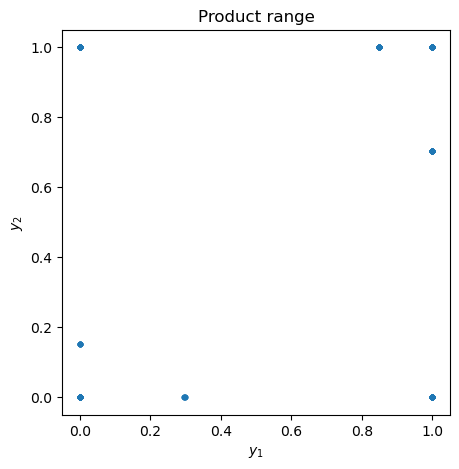

In [404]:
model.range(title='Product range', s=10,) #path='results/'+model.id)
# model.constraints()

## Setting 3

In [16]:
### Types setting
n0, n1 = 4,4
theta0, theta1 =  np.linspace(0, 1, num=n0+1, dtype=np.float32), np.linspace(0, 1, num=n1+1, dtype=np.float32)  #  [1, 1.5, 3], [0, 0.5, 1]
theta0 = (theta0[1:]+theta0[:-1])/2 ; theta1 = (theta1[1:]+theta1[:-1])/2
theta0, theta1 = np.meshgrid(theta0,theta1)
theta = np.stack((theta0.flatten(), theta1.flatten())); N = theta.shape[-1] # number of types

f = (1-theta[0])*(1-theta[1])
# f = f / np.sum(f)  # weights of the distribution
f = f / np.min(f)

### Model parameters setting
param = {'substituable':False}   # False for indivisible goods (constraints = cube), True for substituable goods (constraints = simplex)

### Objects
model = LinearMonopolist(theta, f, param)
model.all()

model id = LinearMonopolist_N16_2024-04-02_11-59-11



In [19]:
f

array([49., 35., 21.,  7., 35., 25., 15.,  5., 21., 15.,  9.,  3.,  7.,
        5.,  3.,  1.], dtype=float32)

convergence = True, iterations = 18022, elapsed time = 0:00:38.274482
primal residual = 9.50e-01 tol, dual residual = 4.14e-02 tol
primal-dual gap = 3.28e-04, optimal value - current value < 8.92e-08 optimal value


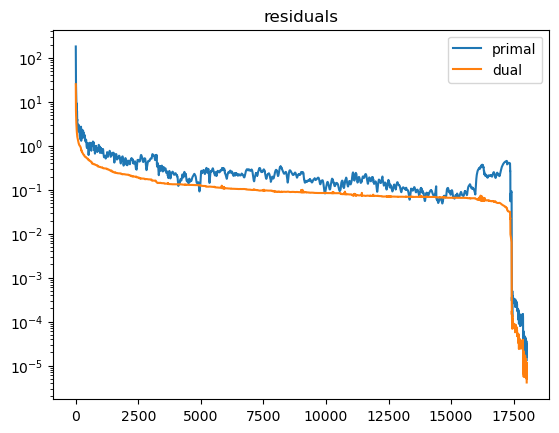

In [19]:
# model.all()
model.solve(warmstart=True, stepratio=100, it_max=2e4, tol_primal=1e-6, tol_dual=1e-6, scale=True,) #path='results/'+model.id
model.residuals(title='residuals')

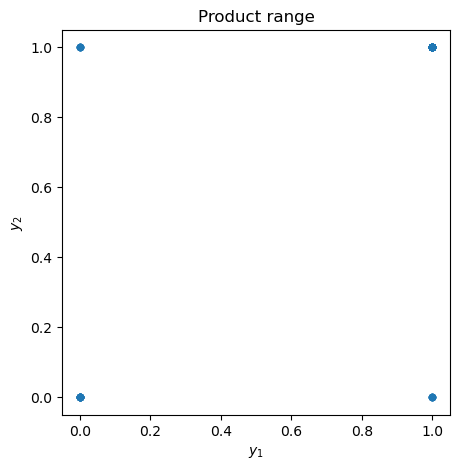

In [20]:
model.range(title='Product range', )

## Setting 4

In [28]:
### Types setting
n0, n1 = 50, 50
theta0, theta1 =  np.linspace(0, 1, num=n0+1, dtype=np.float32), np.linspace(0, 1, num=n1+1, dtype=np.float32)  #  [1, 1.5, 3], [0, 0.5, 1]
theta0 = (theta0[1:]+theta0[:-1])/2 ; theta1 = (theta1[1:]+theta1[:-1])/2
theta0, theta1 = np.meshgrid(theta0,theta1)
theta = np.stack((theta0.flatten(), theta1.flatten())); N = theta.shape[-1] # number of types

f = (1-theta[0])*(1-theta[1])
# f = f / np.sum(f)  # weights of the distribution
f = f / np.min(f)

### Objects
model = LinearMonopolist(theta, f)
# model.all()

model id = LinearMonopolist_N2500_2024-02-13_14-22-45



In [29]:
kmax = ceil(sqrt(N))+1
t_start = timer()
model.local(); k = 0; test = np.array([False,False])
while np.all(test==False):
    k += 1
    print(f'OPTIMIZATION {k}: {len(model.indices)} IC constraints')
    model.solve(warmstart=True, it_max = 1e4, stepratio=1,) # path='results/'+model.id) #sqrt(len(model.indices)) #len(model.indices)
    # model.residuals()
    print(f'IC constraints: {len(model.IC_binding)} binding, {len(model.IC_violated)} violated\n')
    # model.indices = sorted(set(model.indices).union(model.IC_violated))
    model.indices = sorted(set(model.indices).union(set(model.IC_violated).intersection(model.ind_local(k*ceil(sqrt(N))))))
    model.local(model.indices)
    test = np.array([k==kmax, len(model.IC_violated)==0])
elapsed = timer() - t_start
print(f'elapsed time = {str(timedelta(seconds=elapsed))}')

OPTIMIZATION 1: 4900 IC constraints
convergence = False, iterations = 10000, elapsed time = 0:01:04.801960
primal residual = 1.40e+04 tol, dual residual = 1.41e+04 tol
primal-dual gap = nan, optimal value - current value < nan optimal value
IC constraints: 4716 binding, 57386 violated

OPTIMIZATION 2: 6428 IC constraints
convergence = False, iterations = 10000, elapsed time = 0:02:06.564101
primal residual = 3.07e+03 tol, dual residual = 1.40e+04 tol
primal-dual gap = nan, optimal value - current value < nan optimal value
IC constraints: 5060 binding, 810079 violated

OPTIMIZATION 3: 40301 IC constraints
convergence = False, iterations = 10000, elapsed time = 0:06:28.748504
primal residual = 5.18e+03 tol, dual residual = 1.89e+04 tol
primal-dual gap = nan, optimal value - current value < nan optimal value
IC constraints: 21666 binding, 2934992 violated

OPTIMIZATION 4: 331743 IC constraints
convergence = False, iterations = 10000, elapsed time = 0:15:41.078738
primal residual = 1.13e+0

In [2]:
model.range(title='Product range', )

NameError: name 'model' is not defined

## Setting 5 (bivariate normal distribution)

model id = LinearMonopolist_N1600_2024-04-02_15-27-59



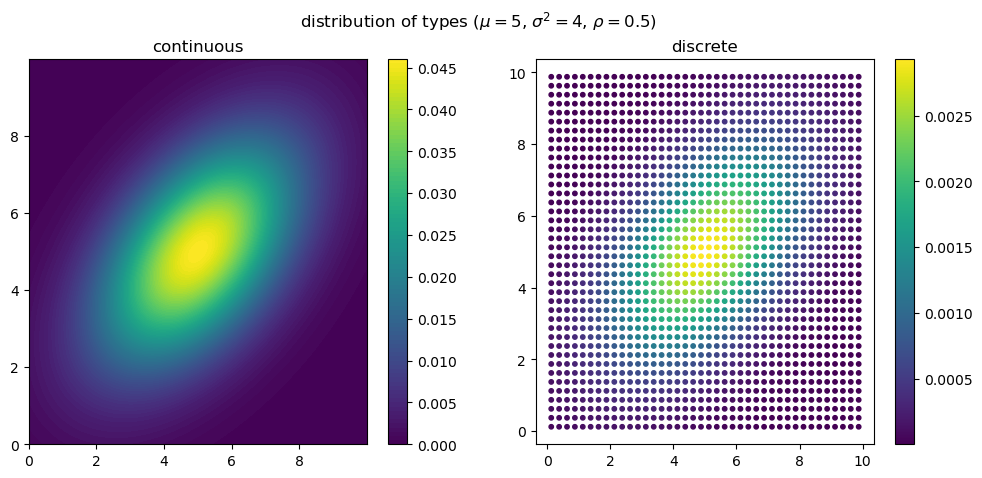

In [197]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

n0, n1 = 40, 40
t0, t1 =  np.linspace(0, 10, num=n0+1, dtype=np.float32), np.linspace(0, 10, num=n1+1, dtype=np.float32)  #  [1, 1.5, 3], [0, 0.5, 1]
theta0 = (t0[1:]+t0[:-1])/2 ; theta1 = (t1[1:]+t1[:-1])/2
theta0, theta1 = np.meshgrid(theta0,theta1)
theta = np.stack((theta0.flatten(), theta1.flatten())); N = theta.shape[-1] # number of types

mu = 5; sigma2 = 4; rho = 0.5
distribution = multivariate_normal(mu*np.array([1, 1]), sigma2*np.array([[1, rho], [rho,1]]))
cd = distribution.cdf(np.dstack(np.meshgrid(t0,t1)))
f = cd[1:,1:] + cd[:-1,:-1] - cd[1:,:-1] - cd[:-1,1:]
f = f.flatten() /  np.sum(f) # weights in the distribution

### Model parameters setting
param = {'substituable':False}   # False for indivisible goods (constraints = cube), True for substituable goods (constraints = simplex)

### Objects
model = LinearMonopolist(theta, f, param)
model.all()


fig, axs = plt.subplots(1,2, figsize=(12,5))
c0, c1 = np.mgrid[np.min(t0):np.max(t0):0.01, np.min(t1):np.max(t1):0.01]
ctypes = axs[0].contourf(c0, c1, distribution.pdf(np.dstack((c0, c1))), 100)
_ = fig.colorbar(ctypes)
_ = axs[0].set_title('continuous')
dtypes = axs[1].scatter(theta0, theta1, c=f, s=10)
_ = fig.colorbar(dtypes)
_ = axs[1].set_title('discrete')
_ = fig.suptitle(rf'distribution of types ($\mu=${mu}, $\sigma^2=${sigma2}, $\rho=${rho})')


In [198]:
path = 'results/Schmalensee/'+model.id+'_distribution'
fig.savefig(path, bbox_inches="tight", pad_inches=0.05)

convergence = True, iterations = 7882, elapsed time = 0:00:44.312614
primal residual = 9.91e-01 tol, dual residual = 8.57e-01 tol
primal-dual gap = -3.25e-04, optimal value - current value < -5.15e-05 optimal value


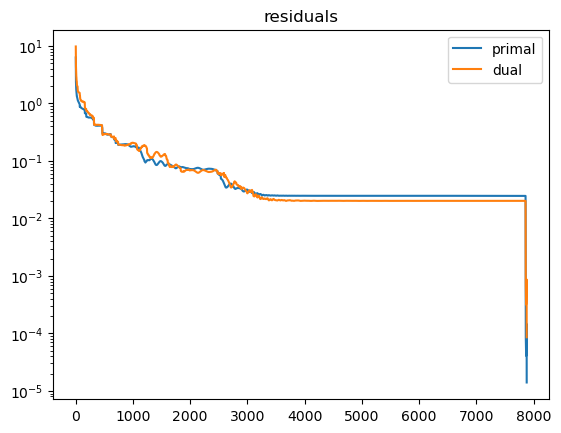

In [168]:
model.all()
model.solve(stepratio=0.5, it_max=1e4, tol_primal=1e-6, tol_dual=1e-6, scale=True,) #path='results/'+model.id
model.residuals(title='residuals')

In [199]:
kmax = ceil(sqrt(N))+1
t_start = timer()
model.local(); k = 0; test = np.array([False,False])
while np.all(test==False):
    k += 1
    print(f'OPTIMIZATION {k}: {len(model.indices)} IC constraints')
    model.solve(warmstart=True, it_max = 1e5, stepratio=1,) # path='results/'+model.id) #sqrt(len(model.indices)) #len(model.indices)
    # model.residuals()
    print(f'IC constraints: {len(model.IC_binding)} binding, {len(model.IC_violated)} violated\n')
    # model.indices = sorted(set(model.indices).union(model.IC_violated))
    model.indices = sorted(set(model.indices).union(set(model.IC_violated).intersection(model.ind_local(k*ceil(sqrt(N))))))
    model.local(model.indices)
    test = np.array([k==kmax, len(model.IC_violated)==0])
elapsed = timer() - t_start
print(f'elapsed time = {str(timedelta(seconds=elapsed))}')


OPTIMIZATION 1: 3120 IC constraints
convergence = True, iterations = 17222, elapsed time = 0:02:27.412943
primal residual = 9.75e-01 tol, dual residual = 9.87e-01 tol
primal-dual gap = -1.80e-04, optimal value - current value < -3.03e-05 optimal value
IC constraints: 3104 binding, 95200 violated

OPTIMIZATION 2: 8522 IC constraints
convergence = False, iterations = 100000, elapsed time = 0:21:31.991071
primal residual = 2.33e+01 tol, dual residual = 5.40e+00 tol
primal-dual gap = nan, optimal value - current value < nan optimal value
IC constraints: 3185 binding, 291375 violated

OPTIMIZATION 3: 40129 IC constraints
convergence = False, iterations = 100000, elapsed time = 0:17:53.928369
primal residual = 3.30e+01 tol, dual residual = 4.96e+00 tol
primal-dual gap = nan, optimal value - current value < nan optimal value
IC constraints: 25495 binding, 226258 violated

OPTIMIZATION 4: 66669 IC constraints
convergence = False, iterations = 100000, elapsed time = 0:07:05.935969
primal residu

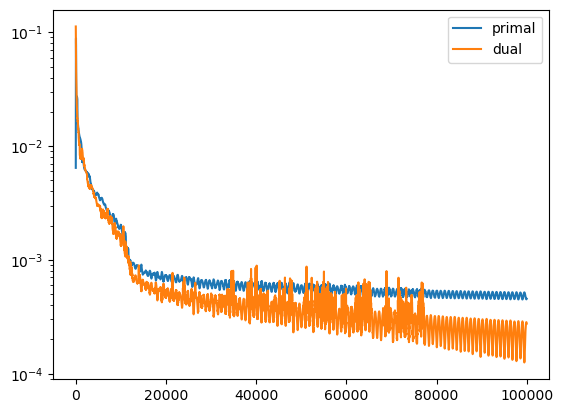

In [200]:
model.residuals()

convergence = False, iterations = 100000, elapsed time = 0:04:35.770868
primal residual = 1.26e+00 tol, dual residual = 4.10e-03 tol
primal-dual gap = 6.69e-04, optimal value - current value < 1.13e-04 optimal value


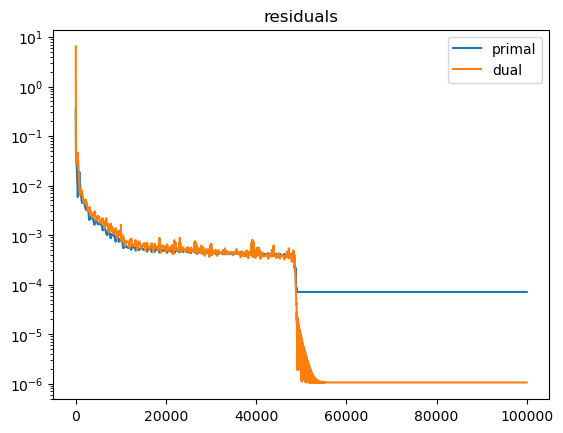

In [201]:
model.solve(warmstart=True, stepratio=0.5, it_max=1e5, tol_primal=1e-6, tol_dual=1e-6, scale=True,) #path='results/'+model.id
model.residuals(title='residuals')

In [202]:
atol = 1e-6
y0_0 = np.isclose(model.y[:model.N],0, atol=atol)
y0_1 = np.isclose(model.y[:model.N],1, atol=atol, rtol=0)
y1_0 = np.isclose(model.y[model.N:],0, atol=atol)
y1_1 = np.isclose(model.y[model.N:],1, atol=atol, rtol=0)

y_00 = np.flatnonzero(np.logical_and(y0_0, y1_0))
y_01 = np.flatnonzero(np.logical_and(y0_0, y1_1))
y_10 = np.flatnonzero(np.logical_and(y0_1, y1_0))
y_11 = np.flatnonzero(np.logical_and(y0_1, y1_1))

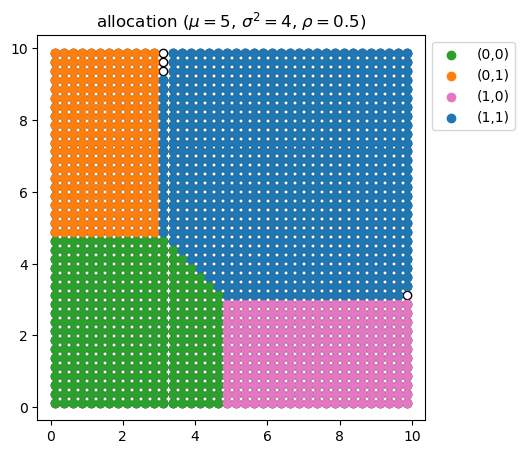

In [203]:
fig, ax = plt.subplots(figsize=(5,5))
_ = ax.scatter(theta[0], theta[1], facecolors='w',edgecolors='k')
_ = ax.scatter(theta[0, y_00], theta[1, y_00], c='tab:green', label='(0,0)')
_ = ax.scatter(theta[0, y_01], theta[1, y_01], c='tab:orange', label='(0,1)')
_ = ax.scatter(theta[0, y_10], theta[1, y_10], c='tab:pink', label='(1,0)')
_ = ax.scatter(theta[0, y_11], theta[1, y_11], c='tab:blue', label='(1,1)')
_ = ax.legend(bbox_to_anchor=(1, 1),loc='upper left') #bbox_to_anchor=(0., -.13, 1., .1), loc='lower left', ncols=4, mode="expand", borderaxespad=0.) #(bbox_to_anchor=(1.02, 1.), loc='lower right')
_ = ax.set_title(rf'allocation ($\mu=${mu}, $\sigma^2=${sigma2}, $\rho=${rho})')


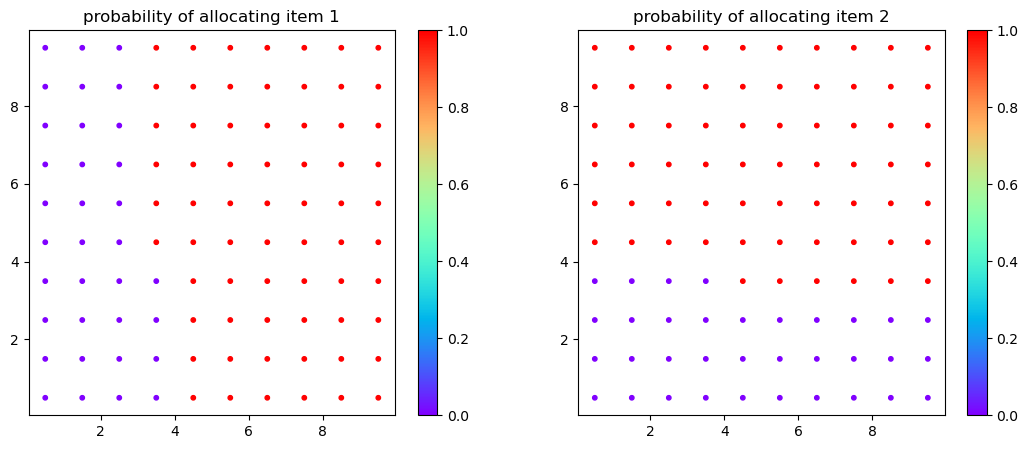

In [171]:
fig, axs = plt.subplots(1,2, figsize=(13,5),) # subplot_kw=dict(aspect='equal',))
item1 = axs[0].scatter(theta[0], theta[1], c = model.y[:model.N], s=10, cmap='rainbow')
_ = fig.colorbar(item1)
_ = axs[0].set_title('probability of allocating item 1')
item2 = axs[1].scatter(theta[0], theta[1], c = model.y[model.N:], s=10, cmap='rainbow')
_ = fig.colorbar(item2)
_ = axs[1].set_title('probability of allocating item 2')
# _ = fig.suptitle(f'c = {c}')

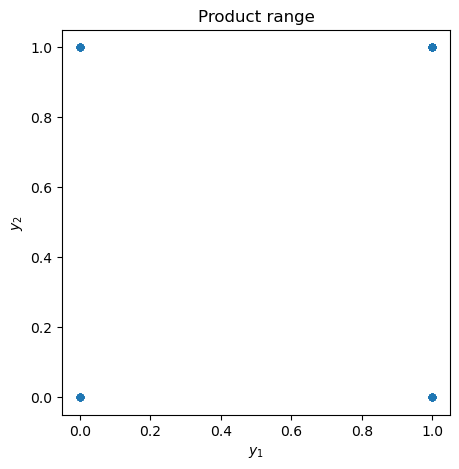

In [177]:
model.range(title='Product range', ) #path='results/'+model.id+'_products')

In [191]:
path = 'results/Schmalensee/'+model.id+'_allocation'
fig.savefig(path, bbox_inches="tight", pad_inches=0.05)

In [185]:
path

'results/Schmalensee/LinearMonopolist_N400_2024-04-02_15-12-19_allocation'